In [1]:
import math
import numpy as np
import torch
from torch import nn
from d2l import torch as d2l

In [2]:
max_degree = 20
n_train, n_test = 100, 100
true_w = np.zeros(max_degree)
true_w[0:4] = np.array([5, 1.2, -3.4, 5.6])

features = np.random.normal(size=(n_train + n_test, 1))
np.random.shuffle(features)

# 这里用了一个广播机制，得到一个矩阵，里面每一行是关于 x 的多项式，也代表着一个数据点
poly_features = np.power(features, np.arange(max_degree).reshape(1, -1))
for i in range(max_degree):
    poly_features[:, i] /= math.gamma(i+1)
labels = np.dot(poly_features, true_w)
labels += np.random.normal(scale=0.1, size=labels.shape)



In [3]:
true_w, features, poly_features, labels = [torch.tensor(x, dtype=
    torch.float32) for x in [true_w, features, poly_features, labels]]

features[:2], poly_features[:2, :], labels[:2]

(tensor([[0.8179],
         [0.7260]]),
 tensor([[1.0000e+00, 8.1791e-01, 3.3449e-01, 9.1193e-02, 1.8647e-02, 3.0503e-03,
          4.1581e-04, 4.8585e-05, 4.9673e-06, 4.5142e-07, 3.6922e-08, 2.7454e-09,
          1.8712e-10, 1.1773e-11, 6.8780e-13, 3.7504e-14, 1.9172e-15, 9.2240e-17,
          4.1913e-18, 1.8043e-19],
         [1.0000e+00, 7.2603e-01, 2.6356e-01, 6.3783e-02, 1.1577e-02, 1.6810e-03,
          2.0341e-04, 2.1098e-05, 1.9147e-06, 1.5446e-07, 1.1214e-08, 7.4015e-10,
          4.4781e-11, 2.5009e-12, 1.2969e-13, 6.2775e-15, 2.8485e-16, 1.2165e-17,
          4.9068e-19, 1.8750e-20]]),
 tensor([5.4862, 5.4294]))

In [4]:
def evaluate_loss(net, data_iter, loss):
    metric = d2l.Accumulator(2)
    for X, y in data_iter:
        out = net(X)
        y = y.reshape(out.shape)
        l = loss(out, y)
        metric.add(l.sum(), l.numel())
    return metric[0] / metric[1]

In [5]:
def train_epoch_ch3(net, train_iter, loss, trainer):
    """训练模型一个迭代周期（定义见第3章）"""
    # 将模型设置为训练模式
    if isinstance(net, torch.nn.Module):
        net.train()
    
    for X, y in train_iter:
        # 1. 前向传播计算梯度
        y_hat = net(X)
        l = loss(y_hat, y)
        
        # 2. 反馈传播
        trainer.zero_grad() # 清除旧梯度
        l.mean().backward() # 计算梯度（取平均值是因为 loss 设置了 reduction='none'）
        
        # 3. 更新参数
        trainer.step()

In [6]:
def train(train_features, test_features, train_labels, test_labels,
          num_epochs=400):
    loss = nn.MSELoss(reduction='none')
    input_shape = train_features.shape[-1]
    # 不设置偏置，因为我们已经在多项式中实现了它
    net = nn.Sequential(nn.Linear(input_shape, 1, bias=False))
    batch_size = min(10, train_labels.shape[0])
    train_iter = d2l.load_array((train_features, train_labels.reshape(-1,1)),
                                batch_size)
    test_iter = d2l.load_array((test_features, test_labels.reshape(-1,1)),
                               batch_size, is_train=False)
    trainer = torch.optim.SGD(net.parameters(), lr=0.01)
    animator = d2l.Animator(xlabel='epoch', ylabel='loss', yscale='log',
                            xlim=[1, num_epochs], ylim=[1e-3, 1e2],
                            legend=['train', 'test'])
    for epoch in range(num_epochs):
        train_epoch_ch3(net, train_iter, loss, trainer)
        if epoch == 0 or (epoch + 1) % 20 == 0:
            animator.add(epoch + 1, (evaluate_loss(net, train_iter, loss),
                                     evaluate_loss(net, test_iter, loss)))
    print('weight:', net[0].weight.data.numpy())

weight: [[ 5.0015697  1.2244704 -3.430569   5.55276  ]]


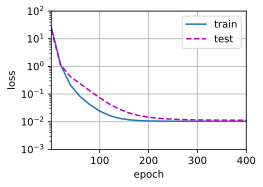

In [7]:
# 从多项式特征中选择前4个维度，即1,x,x^2/2!,x^3/3!
train(poly_features[:n_train, :4], poly_features[n_train:, :4],
      labels[:n_train], labels[n_train:])

weight: [[2.8730757 4.2786126]]


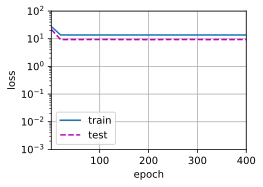

In [8]:
# 从多项式特征中选择前2个维度，即1和x
train(poly_features[:n_train, :2], poly_features[n_train:, :2],
      labels[:n_train], labels[n_train:])

weight: [[ 5.0031147   1.3083408  -3.453517    5.1121397   0.06239646  1.2001151
   0.28134078  0.12234575  0.03856591 -0.20210905  0.12675714 -0.1434825
   0.12628274  0.04930457 -0.15907608 -0.02491046 -0.10898198  0.03137057
  -0.02181331  0.2159619 ]]


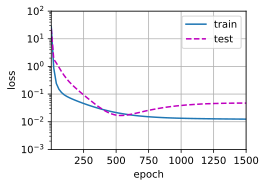

In [9]:
# 从多项式特征中选取所有维度
train(poly_features[:n_train, :], poly_features[n_train:, :],
      labels[:n_train], labels[n_train:], num_epochs=1500)